In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from lib.d2l_torch import Seq2SeqEncoder, Decoder, AdditiveAttention, init_seq2seq, MTFraEng, Seq2Seq, Trainer, bleu, show_heatmaps, try_gpu, try_gpu

In [2]:
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface.
    """
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        """这里主要用于获得 attention weight, 来绘制图形
        """
        raise NotImplementedError

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    """Encoder 部分是没有改变的, Decoder 部分加入了 Attention.
    """
    def __init__(
                self, 
                vocab_size, 
                embed_size, 
                num_hiddens, 
                num_layers,
                dropout=0
            ):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout) # 加性 Attention
        self.embedding = nn.Embedding(vocab_size, embed_size) # Embedding 层
        self.rnn = nn.GRU(
            embed_size + num_hiddens, 
            num_hiddens, 
            num_layers,
            dropout=dropout
        )
        self.dense = nn.LazyLinear(vocab_size) # 输出每一个词的概率
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        # enc_valid_lens, 表示 encode 句子中哪些是 padding 的
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # 这里 num_steps 是原始句子的长度
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens). 每一的 output --> 作为 key 和 value
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens), final hidden state
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)

        # #####################
        # 下面用到了 Attention 的机制
        # #####################
        outputs, self._attention_weights = [], []
        for x in X: # 每一个字
            # Shape of query: (batch_size, 1, num_hiddens)
            # query 是上一个时间的 RNN 的输出, 其实就是上一个字 Embedding 的结果
            query = torch.unsqueeze(hidden_state[-1], dim=1) # 只取最后一个 layer 的结果
            # Shape of context: (batch_size, 1, num_hiddens)
            # Shape of enc_outputs: (batch size, num_steps, h)
            # query, key, value
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens) # context 是如何计算的
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1) # context 和 x 合并起来
            # Reshape x from (batch_size, 1, embed_size + num_hiddens) to (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights) # 存储 attention weights
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

## 开始训练

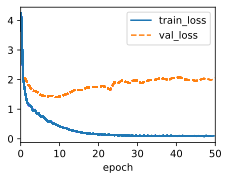

In [4]:
data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 分析模型结果

In [5]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calme', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


### 可视化 Attention 结果

In [6]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), try_gpu(), data.num_steps, True)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0).reshape((1,
    1, -1, data.num_steps))

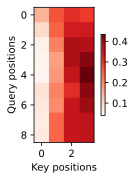

In [7]:
# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions'
)